# Introduction and Data Description
## Features
* State
* Year - (2014 - 2020)
* Date - (MM/DD/YY)
* Unemployment Rate - Percentage of labor force without employment
* Subsidies (millions of dollars) - Government subsidies, negative values indicate outflow
* Taxes on production and imports (TOPI) - Tax revenue in millions of dollars
* Chain-type quantity indexes for real GDP - Measure of real economic output
* Compensation (millions of dollars) - Total employee compensation
* Current-dollar GDP - Nominal GDP without inflation adjustment
* Real GDP (millions of chained 2017 dollars) - Inflation-adjusted GDP
* State.Minimum.Wage - State-mandated minimum wage (0 indicates federal min wage adoption?)
* State.Minimum.Wage.2020.Dollars - Inflation-adjusted state minimum wage
* Federal.Minimum.Wage - Federal minimum wage
* Federal.Minimum.Wage.2020.Dollars - Inflation-adjusted federal minimum wage
* Effective.Minimum.Wage - Higher of state or federal minimum wage
* Effective.Minimum.Wage.2020.Dollars - Inflation-adjusted effective minimum wage
* CPI.Average - Consumer Price Index average

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import graphviz
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler


/var/folders/dc/0_k_wcr110d8fyz7ddwgcq3m0000gn/T/ipykernel_33912/593554761.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


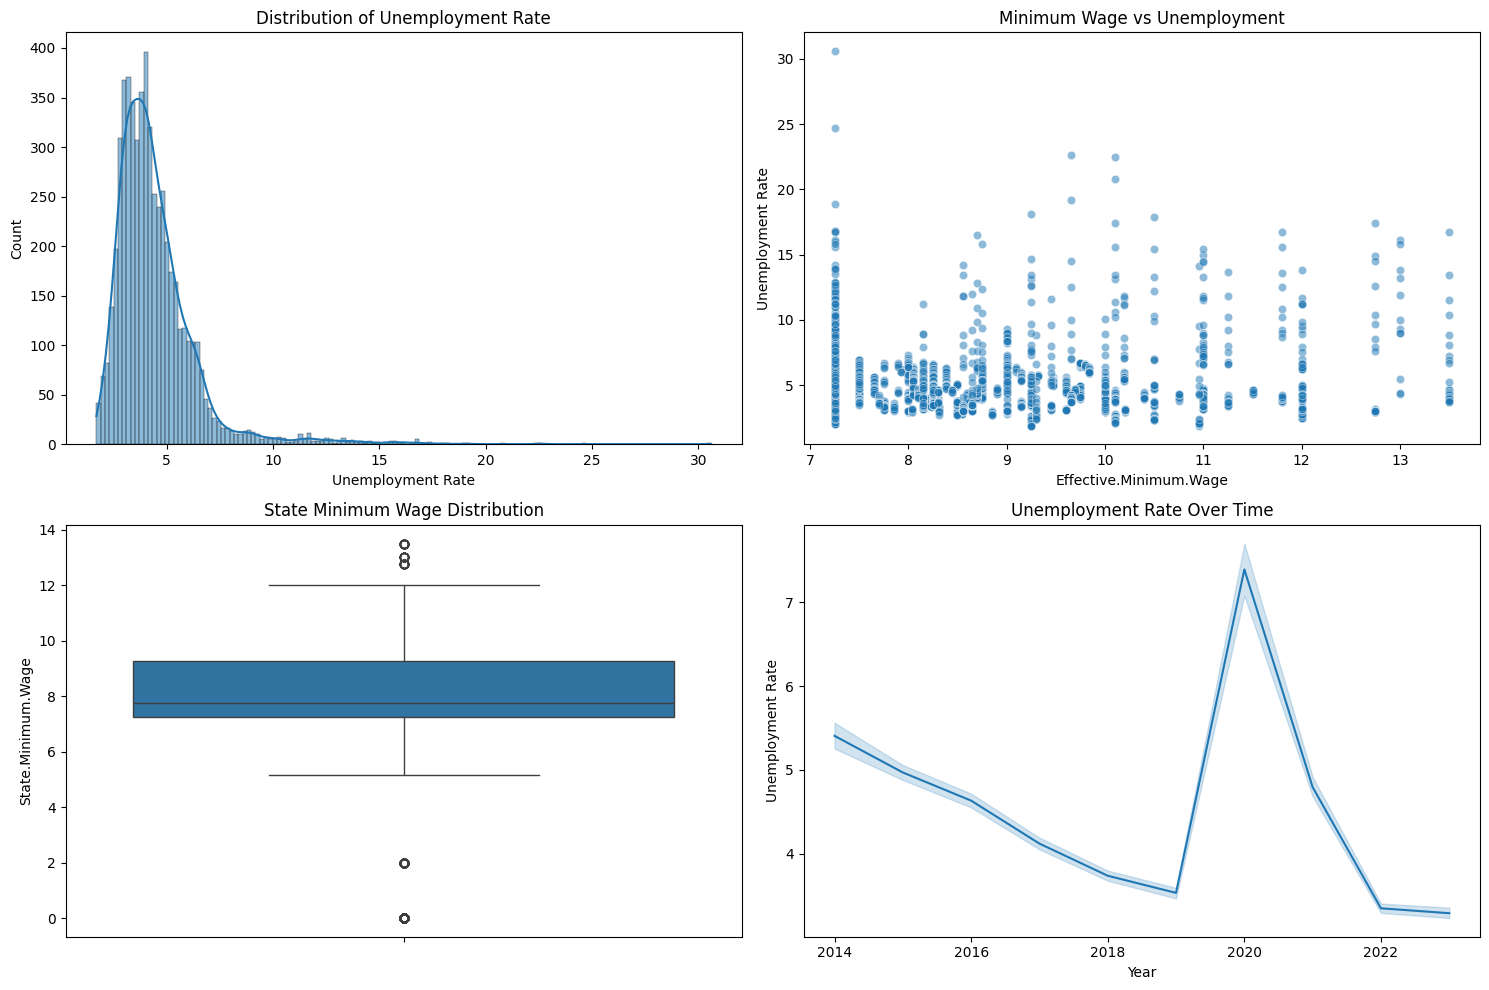


Summary Statistics:
              Year  Unemployment Rate    Subsidies (millions of dollars)  \
count  5600.000000        5600.000000                        5600.000000   
mean   2018.821429           4.460089                       -3985.415857   
std       2.700156           1.975145                        8433.248673   
min    2014.000000           1.700000                      -75069.100000   
25%    2016.750000           3.300000                       -3159.700000   
50%    2019.000000           4.000000                       -1300.000000   
75%    2021.000000           5.100000                        -605.300000   
max    2023.000000          30.600000                         -85.500000   

         Taxes on production and imports (TOPI) (millions of dollars)  \
count                                        5600.000000                
mean                                        30561.938929                
std                                         40229.049383                
mi

In [24]:
# Load data
data = pd.read_csv('UnemploymentGDP.csv')

# Create summary statistics function
def generate_summary_stats(df):
    # Basic statistics for numeric columns
    numeric_stats = df.select_dtypes(include=[np.number]).describe()

    # Missing values count
    missing_values = df.isnull().sum()

    # Data types
    dtypes = df.dtypes

    return numeric_stats, missing_values, dtypes

# Clean and format date
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month_Num'] = data['Date'].dt.month

# Ensure unemployment is numeric
data['Unemployment Rate'] = pd.to_numeric(data['Unemployment Rate'], errors='coerce')

# Generate summary statistics
numeric_stats, missing_values, dtypes = generate_summary_stats(data)

# Create visualization of key metrics
plt.figure(figsize=(15, 10))

# Subplot 1: Distribution of Unemployment
plt.subplot(2, 2, 1)
sns.histplot(data['Unemployment Rate'], kde=True)
plt.title('Distribution of Unemployment Rate')

# Subplot 2: Minimum Wage vs Unemployment
plt.subplot(2, 2, 2)
sns.scatterplot(data=data,
                x='Effective.Minimum.Wage',
                y='Unemployment Rate',
                alpha=0.5)
plt.title('Minimum Wage vs Unemployment')

# Subplot 3: State Minimum Wage Distribution
plt.subplot(2, 2, 3)
sns.boxplot(data=data, y='State.Minimum.Wage')
plt.title('State Minimum Wage Distribution')

# Subplot 4: Time Series of Unemployment
plt.subplot(2, 2, 4)
sns.lineplot(data=data, x='Year', y='Unemployment Rate')
plt.title('Unemployment Rate Over Time')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(numeric_stats)
print("\nMissing Values:")
print(missing_values[missing_values > 0])
print("\nData Types:")
print(dtypes)

# Descriptive Analysis

In [25]:
data = pd.read_csv('longform.csv')

state = data.groupby('Year')[['(%)', 'Minimum Wage']].mean().sort_index().reset_index()

print(state.head())

   Year       (%)  Minimum Wage
0  2013  7.344218      7.265992
1  2014  6.224371      7.355578
2  2016  5.229787      7.675820
3  2017  4.588914      7.806703
4  2018  4.108315      7.927420


In [26]:
X = sm.add_constant(state['Minimum Wage'])
y = state['(%)']
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    (%)   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     6.825
Date:                Thu, 05 Dec 2024   Prob (F-statistic):             0.0310
Time:                        02:55:32   Log-Likelihood:                -13.546
No. Observations:                  10   AIC:                             31.09
Df Residuals:                       8   BIC:                             31.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           16.0791      4.253      3.781   

/Users/taranbains/miniconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


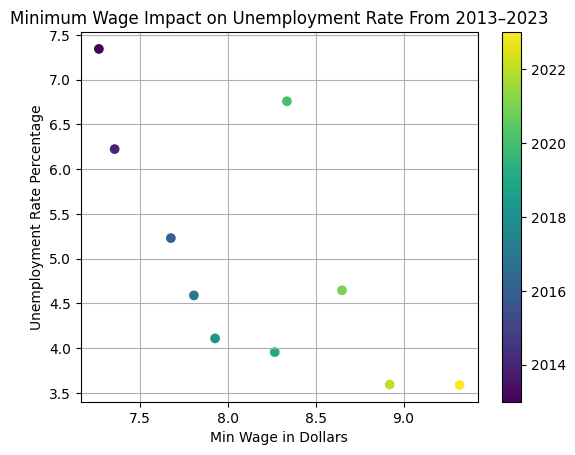

In [27]:
scatterplot = plt.scatter(state['Minimum Wage'], state['(%)'], c=state['Year'])


plt.xlabel("Min Wage in Dollars")
plt.ylabel("Unemployment Rate Percentage")
plt.title("Minimum Wage Impact on Unemployment Rate From 2013–2023")
plt.grid()
plt.colorbar(scatterplot)

plt.show()

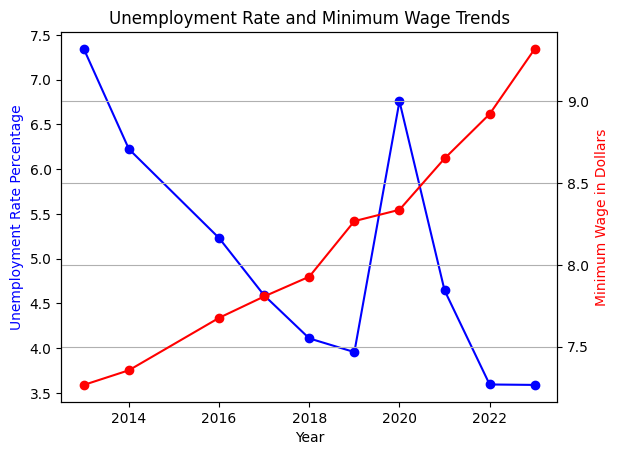

In [28]:
fig, ax1 = plt.subplots()

# left y-axis
ax1.plot(state['Year'], state['(%)'],color='blue', label='Unemployment Rate Percentage', marker='o')
ax1.set_xlabel("Year")
ax1.set_ylabel("Unemployment Rate Percentage", color='blue')

# right y-axis
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
ax2.plot(state['Year'], state['Minimum Wage'], color='red', label='Minimum Wage ($)',marker='o')
ax2.set_ylabel("Minimum Wage in Dollars", color='red')
plt.grid()
plt.title("Unemployment Rate and Minimum Wage Trends")
plt.show()

# Rural vs Urban Analysis

In [29]:
data = pd.read_csv('County Minimum Wage- Unemployment.csv')
data.head()

,State,County Name/State Abbreviation,Force_13,Employed_13,Unemployed_13,(%)_13,Unemployed_14,(%)_14,Labor Force_16,Employed_16,...,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2014,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2015,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2016,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2017,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2018,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2019,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2020,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2021,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2022,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2023
0,Alabama,Autauga County,"25,783","24,155","1,628",6.3,"1,489",5.8,"25,710","24,395",...,11784.9,11675.1,12435.7,12881.0,13578.5,13965.9,7495.8,9521.0,16663.0,17306.7
1,Alabama,Baldwin County,"85,206","79,466","5,740",6.7,"5,281",6.1,"89,778","84,972",...,11784.9,11675.1,12435.7,12881.0,13578.5,13965.9,7495.8,9521.0,16663.0,17306.7
2,Alabama,Barbour County,"9,096","8,152",944,10.4,929,10.5,"8,334","7,638",...,11784.9,11675.1,12435.7,12881.0,13578.5,13965.9,7495.8,9521.0,16663.0,17306.7
3,Alabama,Bibb County,"8,699","8,000",699,8.0,614,7.2,"8,539","7,986",...,11784.9,11675.1,12435.7,12881.0,13578.5,13965.9,7495.8,9521.0,16663.0,17306.7
4,Alabama,Blount County,"24,860","23,277","1,583",6.4,"1,497",6.1,"24,380","23,061",...,11784.9,11675.1,12435.7,12881.0,13578.5,13965.9,7495.8,9521.0,16663.0,17306.7


In [30]:
data.columns

Index(['State', 'County Name/State Abbreviation', 'Force_13', 'Employed_13',
       'Unemployed_13', '(%)_13', 'Unemployed_14', '(%)_14', 'Labor Force_16',
       'Employed_16',
       ...
       'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2014',
       'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2015',
       'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2016',
       'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2017',
       'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2018',
       'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2019',
       'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2020',
       'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2021',
       'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2022',
 

In [31]:
data['(%)_23']

0       2.2
1       2.3
2       4.4
3       2.5
4       2.1
       ... 
3134    3.3
3135    2.1
3136    3.2
3137    3.3
3138    2.1
Name: (%)_23, Length: 3139, dtype: float64

In [32]:
missing = data.isnull().sum()
data_types = data.dtypes
missing[missing > 0], data_types.value_counts()

(Minimum Wage 2013    237
 Minimum Wage 2014    269
 Minimum Wage 2015    269
 Minimum Wage 2016    269
 Minimum Wage 2017    181
 Minimum Wage 2018    181
 Minimum Wage 2019    181
 Minimum Wage 2020     94
 Minimum Wage 2021     94
 Minimum Wage 2022     94
 Minimum Wage 2023     94
 Population_2010       18
 RUCC_2013             18
 Description_x         18
 FIPS                  20
 Population_2020       20
 RUCC_2023             20
 Description_y         20
 dtype: int64,
 float64    79
 object     35
 int64       1
 Name: count, dtype: int64)

In [33]:
keys = ["Minimum Wage 2013","Minimum Wage 2023","Population_2010",
        "Population_2020","RUCC_2013","RUCC_2023"]

data_clean = data.dropna(subset=keys)

data_clean.rename(columns={
    "RUCC_2013": "RUCC",
    "Minimum Wage 2023": "Min_Wage_2023",
    "Population_2020": "Pop_2020"
}, inplace=True)

data_clean.head()

/var/folders/dc/0_k_wcr110d8fyz7ddwgcq3m0000gn/T/ipykernel_33912/3616787374.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.rename(columns={


,State,County Name/State Abbreviation,Force_13,Employed_13,Unemployed_13,(%)_13,Unemployed_14,(%)_14,Labor Force_16,Employed_16,...,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2014,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2015,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2016,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2017,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2018,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2019,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2020,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2021,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2022,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2023
0,Alabama,Autauga County,"25,783","24,155","1,628",6.3,"1,489",5.8,"25,710","24,395",...,11784.9,11675.1,12435.7,12881.0,13578.5,13965.9,7495.8,9521.0,16663.0,17306.7
1,Alabama,Baldwin County,"85,206","79,466","5,740",6.7,"5,281",6.1,"89,778","84,972",...,11784.9,11675.1,12435.7,12881.0,13578.5,13965.9,7495.8,9521.0,16663.0,17306.7
2,Alabama,Barbour County,"9,096","8,152",944,10.4,929,10.5,"8,334","7,638",...,11784.9,11675.1,12435.7,12881.0,13578.5,13965.9,7495.8,9521.0,16663.0,17306.7
3,Alabama,Bibb County,"8,699","8,000",699,8.0,614,7.2,"8,539","7,986",...,11784.9,11675.1,12435.7,12881.0,13578.5,13965.9,7495.8,9521.0,16663.0,17306.7
4,Alabama,Blount County,"24,860","23,277","1,583",6.4,"1,497",6.1,"24,380","23,061",...,11784.9,11675.1,12435.7,12881.0,13578.5,13965.9,7495.8,9521.0,16663.0,17306.7


In [34]:
missing_clean = data_clean.isnull().sum()
data_clean.info(), missing_clean[missing_clean > 0]

<class 'pandas.core.frame.DataFrame'>
Index: 2875 entries, 0 to 3138
Columns: 115 entries, State to Taxes on production and imports (TOPI) less subsides (millions of dollars) 2023
dtypes: float64(79), int64(1), object(35)
memory usage: 2.5+ MB


(None,
 Minimum Wage 2014    88
 Minimum Wage 2015    88
 Minimum Wage 2016    88
 dtype: int64)

In [35]:
wage_cols = [col for col in data_clean.columns if "Minimum Wage" in col]
unemployment_cols = [col for col in data_clean.columns if "Unemployed" in col and "%" not in col]
data_clean[unemployment_cols] = data_clean[unemployment_cols].apply(pd.to_numeric, errors='coerce')

avg_min_wage = data_clean[wage_cols].mean()
avg_unemployment = data_clean[unemployment_cols].mean()

years = list(range(2013, 2023))

rural = data_clean[data_clean["RUCC"] > 3]
urban = data_clean[data_clean["RUCC"] <= 3]

rural_avg_unemployment = rural[unemployment_cols].mean()
urban_avg_unemployment = urban[unemployment_cols].mean()
rural_avg_unemployment.shape, urban_avg_unemployment.shape

/var/folders/dc/0_k_wcr110d8fyz7ddwgcq3m0000gn/T/ipykernel_33912/2360419198.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean[unemployment_cols] = data_clean[unemployment_cols].apply(pd.to_numeric, errors='coerce')


((10,), (10,))

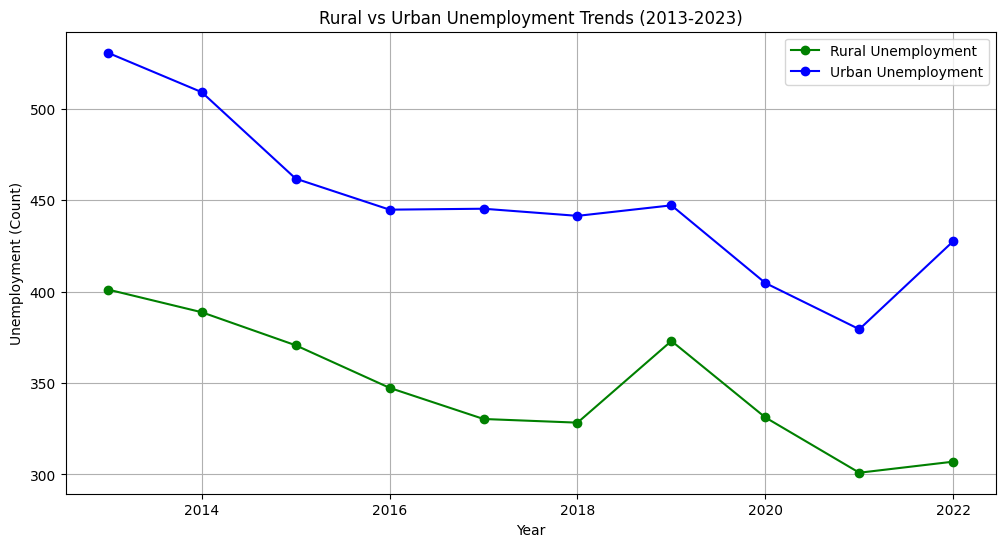

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(years, rural_avg_unemployment.values, label="Rural Unemployment", marker='o', color='green')
plt.plot(years, urban_avg_unemployment.values, label="Urban Unemployment", marker='o', color='blue')
plt.title("Rural vs Urban Unemployment Trends (2013-2023)")
plt.xlabel("Year")
plt.ylabel("Unemployment (Count)")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
data_clean["Rural"] = (data_clean["RUCC"] > 3).astype(int)
data_clean["Rural"]

/var/folders/dc/0_k_wcr110d8fyz7ddwgcq3m0000gn/T/ipykernel_33912/2531859581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean["Rural"] = (data_clean["RUCC"] > 3).astype(int)


0       0
1       0
2       1
3       0
4       0
       ..
3134    1
3135    1
3136    1
3137    1
3138    1
Name: Rural, Length: 2875, dtype: int64

In [38]:
reg_data = data_clean[["Min_Wage_2023", "(%)_13", "Rural"]].dropna()
print(data_clean['Min_Wage_2023'])

0       7.25
1       7.25
2       7.25
3       7.25
4       7.25
        ... 
3134    5.15
3135    5.15
3136    5.15
3137    5.15
3138    5.15
Name: Min_Wage_2023, Length: 2875, dtype: float64


In [39]:
X = reg_data[["Min_Wage_2023", "Rural"]]
X = sm.add_constant(X)
y = reg_data['(%)_13']

mod = sm.OLS(y, X).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                 (%)_13   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     11.44
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           1.12e-05
Time:                        02:55:33   Log-Likelihood:                -6857.7
No. Observations:                2875   AIC:                         1.372e+04
Df Residuals:                    2872   BIC:                         1.374e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.6553      0.185     35.881

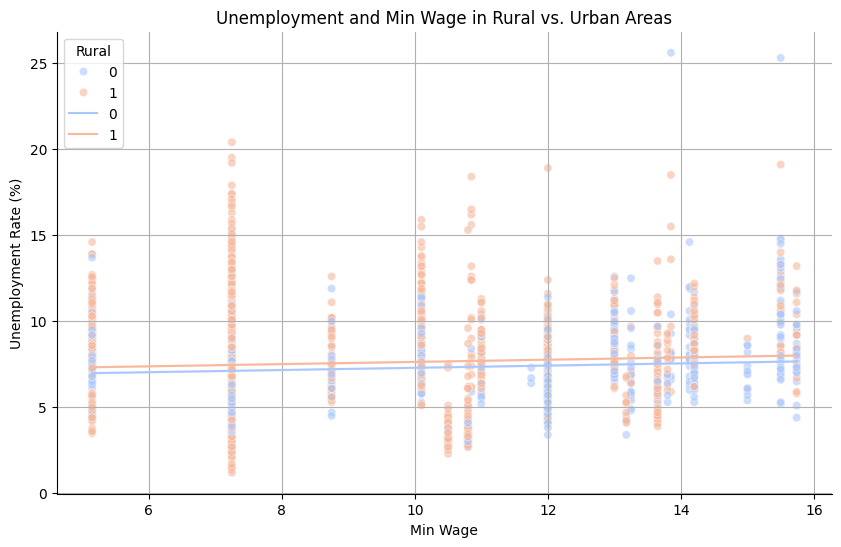

In [40]:
reg_data['Predict'] = mod.predict(X)

plt.figure(figsize=(10,6))
sns.scatterplot(data=reg_data,
                x='Min_Wage_2023',
                y='(%)_13',
                hue='Rural',
                palette="coolwarm",
                alpha=0.6)
sns.lineplot(data=reg_data,
            x='Min_Wage_2023',
            y='Predict',
            hue='Rural',
            palette="coolwarm")
plt.title('Unemployment and Min Wage in Rural vs. Urban Areas')
plt.xlabel('Min Wage')
plt.ylabel('Unemployment Rate (%)')
plt.grid(True)
sns.despine()
plt.show()

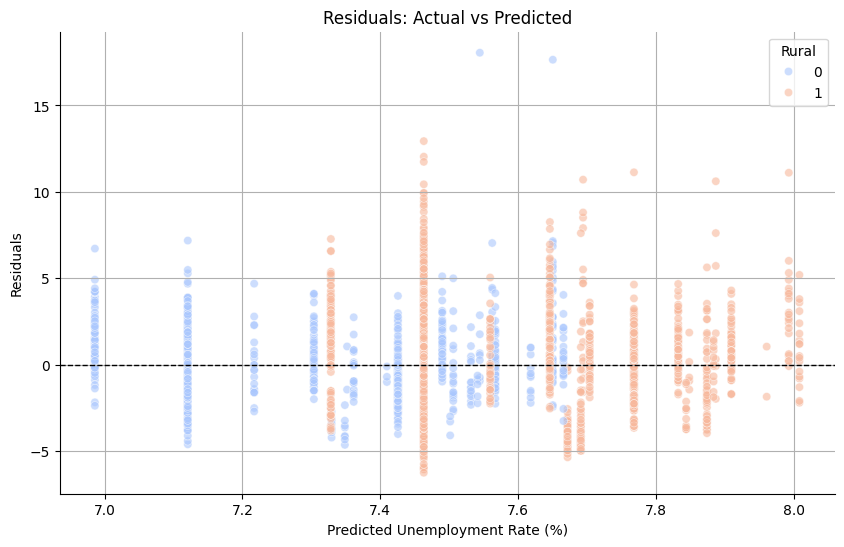

In [41]:
reg_data['Residuals'] = y - reg_data['Predict']

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=reg_data,
    x="Predict",
    y="Residuals",
    hue="Rural",
    palette="coolwarm",
    alpha=0.6
)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Residuals: Actual vs Predicted")
plt.xlabel("Predicted Unemployment Rate (%)")
plt.ylabel("Residuals")
plt.grid(True)
sns.despine()
plt.show()

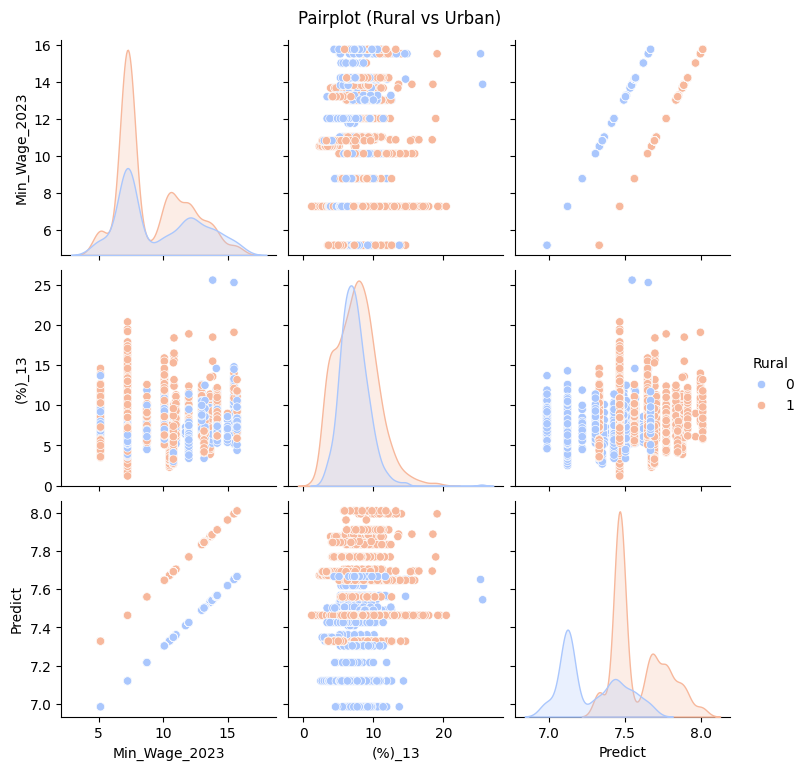

In [42]:
sns.pairplot(
    reg_data,
    vars=["Min_Wage_2023", "(%)_13", "Predict"],
    hue="Rural",
    palette="coolwarm",
    diag_kind="kde",
)
plt.suptitle("Pairplot (Rural vs Urban)", y=1.02)
sns.despine()
plt.show()

In [43]:
overall_corr = reg_data[['Min_Wage_2023', '(%)_13']].corr().iloc[0, 1]
rural_corr = reg_data[reg_data['Rural'] == 1][['Min_Wage_2023', '(%)_13']].corr().iloc[0, 1]
urban_corr = reg_data[reg_data['Rural'] == 0][['Min_Wage_2023', '(%)_13']].corr().iloc[0, 1]

X_1 = reg_data[['Min_Wage_2023', 'Rural']]
X_1 = sm.add_constant(X_1)
y_1 = reg_data['(%)_13']
overall_mod = sm.OLS(y_1, X_1).fit()
print(overall_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                 (%)_13   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     11.44
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           1.12e-05
Time:                        02:55:35   Log-Likelihood:                -6857.7
No. Observations:                2875   AIC:                         1.372e+04
Df Residuals:                    2872   BIC:                         1.374e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.6553      0.185     35.881

In [44]:
rural_data = reg_data[reg_data['Rural'] == 1]
X_rural = sm.add_constant(rural_data['Min_Wage_2023'])
y_rural = rural_data['(%)_13']
rural_mod = sm.OLS(y_rural, X_rural).fit()
print(rural_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                 (%)_13   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.429
Date:                Thu, 05 Dec 2024   Prob (F-statistic):             0.0642
Time:                        02:55:35   Log-Likelihood:                -4437.3
No. Observations:                1779   AIC:                             8879.
Df Residuals:                    1777   BIC:                             8890.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.1403      0.248     28.765

In [45]:
urban_data = reg_data[reg_data['Rural'] == 0]
X_urban = sm.add_constant(urban_data['Min_Wage_2023'])
y_urban = urban_data['(%)_13']
urban_mod = sm.OLS(y_urban, X_urban).fit()
print(urban_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                 (%)_13   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     17.21
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           3.61e-05
Time:                        02:55:35   Log-Likelihood:                -2337.8
No. Observations:                1096   AIC:                             4680.
Df Residuals:                    1094   BIC:                             4690.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.4736      0.203     31.906

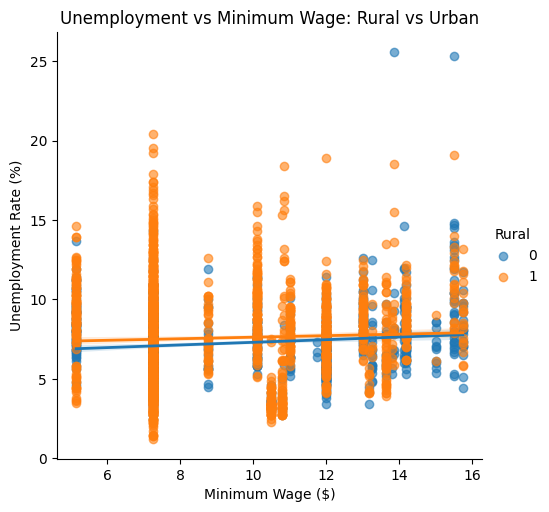

In [46]:
sns.lmplot(
    data=reg_data,
    x="Min_Wage_2023",
    y="(%)_13",
    hue="Rural",
    scatter_kws={'alpha': 0.6},
    line_kws={'linewidth': 2}
)
plt.title("Unemployment vs Minimum Wage: Rural vs Urban")
plt.xlabel("Minimum Wage ($)")
plt.ylabel("Unemployment Rate (%)")
plt.show()

In [47]:
rural_data = data_clean[data_clean['Rural'] == 1]['(%)_13']
urban_data = data_clean[data_clean['Rural'] == 0]['(%)_13']

t_stat, t_pval = ttest_ind(rural_data, urban_data, equal_var=False)
t_stat, t_pval

(np.float64(3.2819305570998756), np.float64(0.0010435332159280221))

/var/folders/dc/0_k_wcr110d8fyz7ddwgcq3m0000gn/T/ipykernel_33912/1837914623.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_clean, x='Rural', y='(%)_13', palette="coolwarm")
/Users/taranbains/miniconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 34.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/taranbains/miniconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 37.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/taranbains/miniconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 26.2% of the points cannot be placed; you may want to decrease the size of the mark

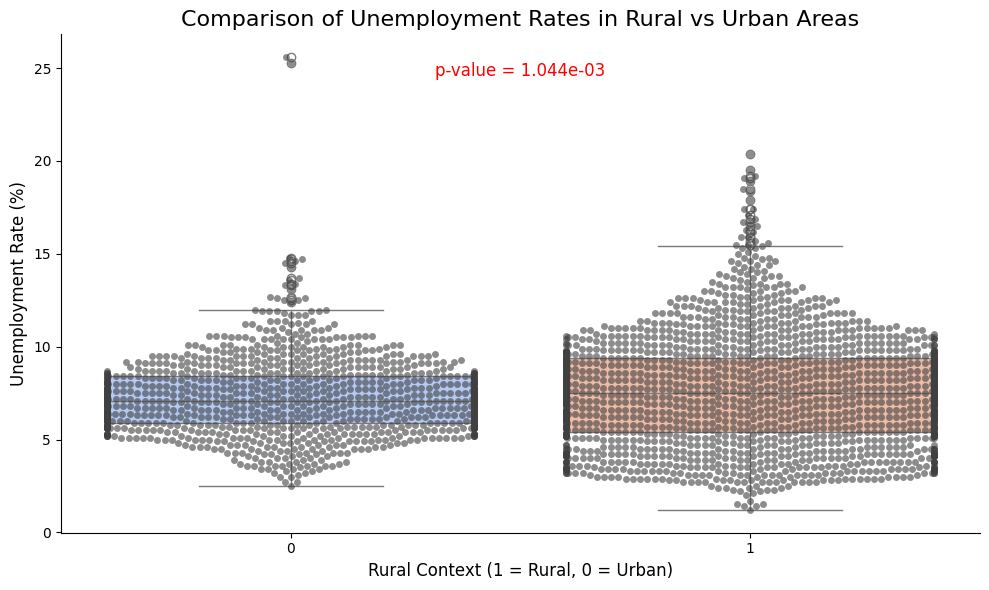

In [48]:
u_stat, u_pval = mannwhitneyu(rural_data, urban_data)
test_stat, test_pval = (u_stat, u_pval) if u_pval < t_pval else (t_stat, t_pval)

plt.figure(figsize=(10, 6))

sns.boxplot(data=data_clean, x='Rural', y='(%)_13', palette="coolwarm")
sns.swarmplot(data=data_clean, x='Rural', y='(%)_13', color=".25", alpha=0.6)

plt.title("Comparison of Unemployment Rates in Rural vs Urban Areas", fontsize=16)
plt.xlabel("Rural Context (1 = Rural, 0 = Urban)", fontsize=12)
plt.ylabel("Unemployment Rate (%)", fontsize=12)

# Annotate with the p-value
plt.text(0.5, max(data_clean['(%)_13']) - 1, f"p-value = {test_pval:.3e}",
         horizontalalignment='center', fontsize=12, color="red")

plt.tight_layout()
sns.despine()
plt.show()

# State Level Analysis

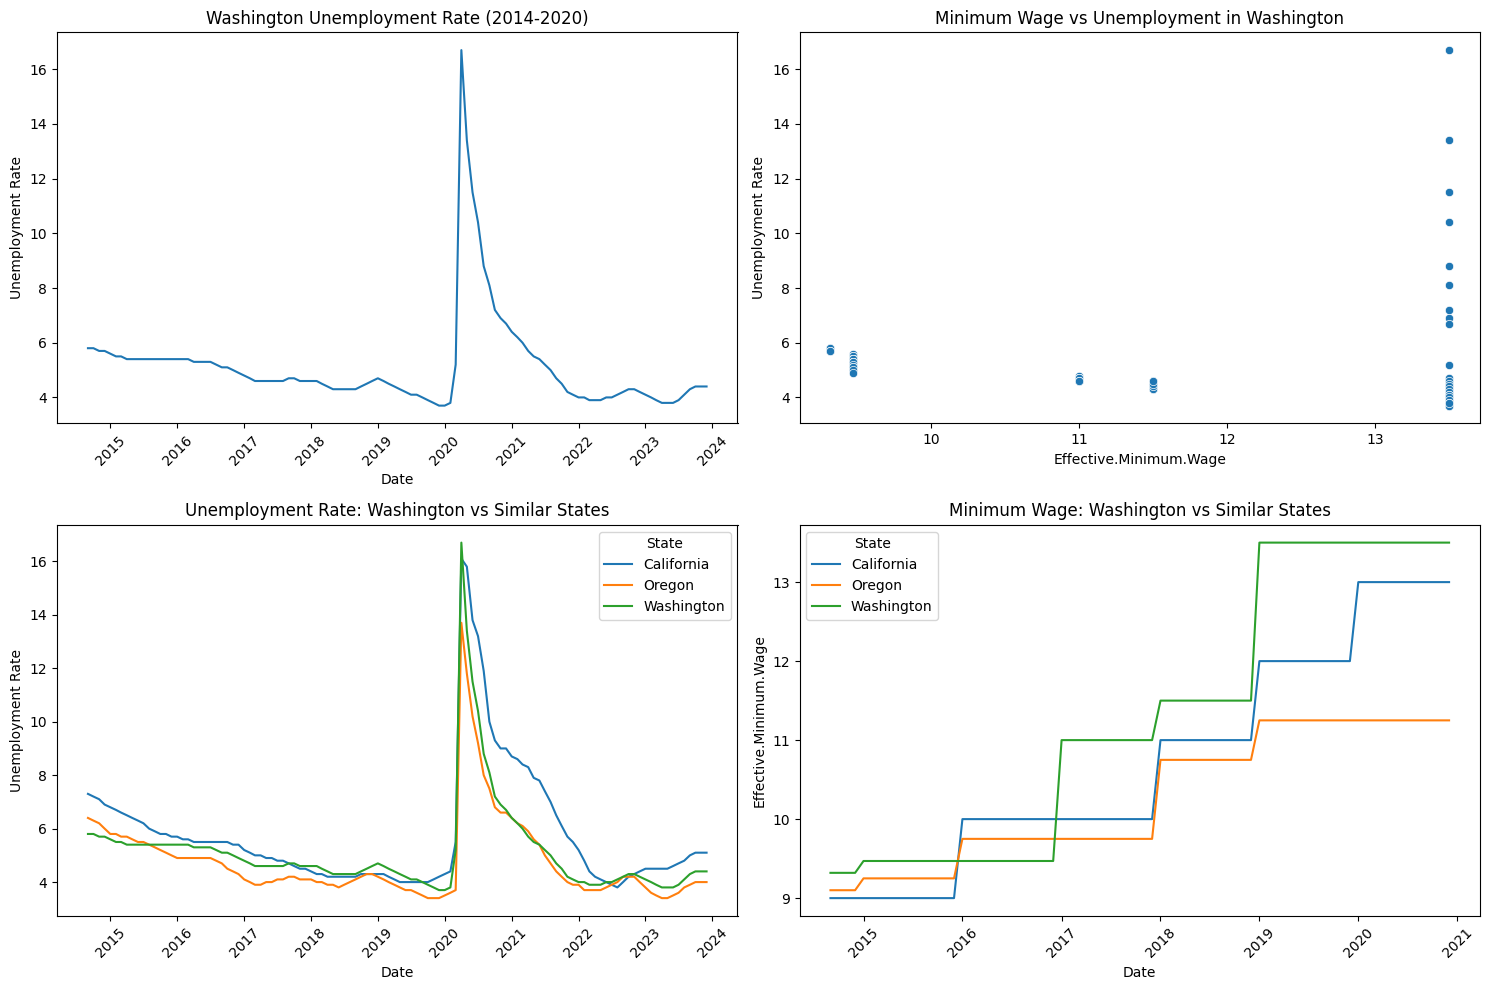


Statistical Summary for Washington:
       Unemployment Rate  Effective.Minimum.Wage
count         112.000000               76.000000
mean            5.116071               11.296842
std             1.812944                1.688291
min             3.700000                9.320000
25%             4.200000                9.470000
50%             4.600000               11.000000
75%             5.400000               13.500000
max            16.700000               13.500000

Correlation between Minimum Wage and Unemployment in Washington: 0.196


In [49]:
data = pd.read_csv('UnemploymentGDP.csv')

def washington_analysis(df):
    # Convert date format
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')

    # Filter for Washington state
    washington_data = df[df['State'] == 'Washington'].copy()

    # Create time series analysis of Washington's metrics
    plt.figure(figsize=(15, 10))

    # Plot 1: Washington Unemployment Rate Over Time
    plt.subplot(2, 2, 1)
    sns.lineplot(data=washington_data, x='Date', y='Unemployment Rate')
    plt.title('Washington Unemployment Rate (2014-2020)')
    plt.xticks(rotation=45)

    # Plot 2: Minimum Wage vs Unemployment in Washington
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=washington_data,
                    x='Effective.Minimum.Wage',
                    y='Unemployment Rate')
    plt.title('Minimum Wage vs Unemployment in Washington')

    # Compare with similar states
    comparable_states = ['California', 'Oregon', 'Washington']
    comparison_data = df[df['State'].isin(comparable_states)].copy()

    # Plot 3: Unemployment Rate Comparison
    plt.subplot(2, 2, 3)
    sns.lineplot(data=comparison_data,
                x='Date',
                y='Unemployment Rate',
                hue='State')
    plt.title('Unemployment Rate: Washington vs Similar States')
    plt.xticks(rotation=45)

    # Plot 4: Minimum Wage Comparison
    plt.subplot(2, 2, 4)
    sns.lineplot(data=comparison_data,
                x='Date',
                y='Effective.Minimum.Wage',
                hue='State')
    plt.title('Minimum Wage: Washington vs Similar States')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Statistical Analysis
    print("\nStatistical Summary for Washington:")
    print(washington_data[['Unemployment Rate', 'Effective.Minimum.Wage']].describe())

    # Correlation Analysis
    correlation = washington_data['Unemployment Rate'].corr(washington_data['Effective.Minimum.Wage'])
    print(f"\nCorrelation between Minimum Wage and Unemployment in Washington: {correlation:.3f}")

    return washington_data, comparison_data

# Run the analysis
washington_analysis, comparison = washington_analysis(data)


# Model Development

In [50]:
long = pd.read_csv('longform.csv')
long_data = long.sort_values(by=['County Name/State Abbreviation', 'Year'])

#king county Linear Regression

king_county_data = long_data[long_data['County Name/State Abbreviation'].str.contains('King', na=False) &
                             long_data['LastTwoLetters'].str.contains('WA', na=False)]
X = king_county_data.drop(['(%)', 'County Name/State Abbreviation', 'LastTwoLetters', 'Description_y','FIPS', 'Unnamed: 14'], axis=1)  # Independent variables
y = king_county_data['(%)']

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Print the intercept and coefficients
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")

# Predict the unemployment rate using the fitted model
predictions = model.predict(X)
print(f"Predictions: {predictions}")

Intercept: 628.7793466803039
Coefficients: [ 1.27554538e-05 -1.73582499e-05  3.01136253e-05 -3.10204674e-01
  3.67674022e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
Predictions: [4.86480763 4.58131612 3.49885476 3.55073792 3.164944   3.10796897
 7.12788071 6.86846575 6.84649826 2.98852589]


In [51]:
long_data1 = long.sort_values(by=['County Name/State Abbreviation', 'Year'])
long_data1 = long_data1.iloc[:, :-1]

data = pd.read_csv('longform.csv')

data['Unemployment_Change'] = data.groupby('County Name/State Abbreviation')['(%)'].diff()
data['Increased_Unemployment'] = (data['Unemployment_Change'] > 0).astype(int)

data = data.dropna(subset=['Unemployment_Change'])

predictors = ['Minimum Wage', 'Population_2010', 'RUCC_2013', 'Population_2020', 'RUCC_2023']
X = data[predictors]
y = data['Increased_Unemployment']

X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

decision_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

dot_data = export_graphviz(
    decision_tree,
    out_file=None,
    feature_names=predictors,
    class_names=['No Increase', 'Increase'],
    filled=True,
    rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")

graph.view()

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.98      0.78      5680
           1       0.58      0.05      0.10      3175

    accuracy                           0.65      8855
   macro avg       0.62      0.52      0.44      8855
weighted avg       0.62      0.65      0.54      8855



'decision_tree.pdf'

# Model Development 2

In [52]:
df= pd.read_csv('County Minimum Wage- Unemployment.csv')

#Dataframe Header
df.head()

,State,County Name/State Abbreviation,Force_13,Employed_13,Unemployed_13,(%)_13,Unemployed_14,(%)_14,Labor Force_16,Employed_16,...,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2014,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2015,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2016,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2017,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2018,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2019,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2020,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2021,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2022,Taxes on production and imports (TOPI) less subsides (millions of dollars) 2023
0,Alabama,Autauga County,"25,783","24,155","1,628",6.3,"1,489",5.8,"25,710","24,395",...,11784.9,11675.1,12435.7,12881.0,13578.5,13965.9,7495.8,9521.0,16663.0,17306.7
1,Alabama,Baldwin County,"85,206","79,466","5,740",6.7,"5,281",6.1,"89,778","84,972",...,11784.9,11675.1,12435.7,12881.0,13578.5,13965.9,7495.8,9521.0,16663.0,17306.7
2,Alabama,Barbour County,"9,096","8,152",944,10.4,929,10.5,"8,334","7,638",...,11784.9,11675.1,12435.7,12881.0,13578.5,13965.9,7495.8,9521.0,16663.0,17306.7
3,Alabama,Bibb County,"8,699","8,000",699,8.0,614,7.2,"8,539","7,986",...,11784.9,11675.1,12435.7,12881.0,13578.5,13965.9,7495.8,9521.0,16663.0,17306.7
4,Alabama,Blount County,"24,860","23,277","1,583",6.4,"1,497",6.1,"24,380","23,061",...,11784.9,11675.1,12435.7,12881.0,13578.5,13965.9,7495.8,9521.0,16663.0,17306.7


In [53]:
# These are my defined features for identifying (%) in 2023. Force # was included to help identify population
# changes. Statewide GDP data was included to help offer monetary correlation in the state as a whole, along with
# RUCC numbers (no change occured across the 10 years of the data set).

# Creating Random Forest Model
rf_model = RandomForestRegressor(random_state=27)

# Removing commas from numeric variables
df = df.apply(lambda x: x.str.replace(',', '', regex=True) if x.dtype == "object" else x)

# Removing all non-important/ potentially dependent variables that might skew the model

variables = ['Force_13', '(%)_13', 'Labor Force_16', 'Labor Force_17', 'Force_18', 'Force_19',
        'Force_20', 'Force_21', 'Force_22', 'Force_23', 'Minimum Wage 2013', 'Minimum Wage 2014', 'Minimum Wage 2015',
        'Minimum Wage 2016', 'Minimum Wage 2017', 'Minimum Wage 2018', 'Minimum Wage 2019', 'Minimum Wage 2020',
        'Minimum Wage 2021', 'Minimum Wage 2022', 'Minimum Wage 2023', 'Population_2010', 'RUCC_2013', 'Population_2020',
        'RUCC_2023', '  Taxes on production and imports (TOPI) (millions of dollars) 2013', '  Taxes on production and imports (TOPI) (millions of dollars) 2014',
        '  Taxes on production and imports (TOPI) (millions of dollars) 2015', '  Taxes on production and imports (TOPI) (millions of dollars) 2016',
        '  Taxes on production and imports (TOPI) (millions of dollars) 2017', '  Taxes on production and imports (TOPI) (millions of dollars) 2018',
        '  Taxes on production and imports (TOPI) (millions of dollars) 2019', '  Taxes on production and imports (TOPI) (millions of dollars) 2020',
        '  Taxes on production and imports (TOPI) (millions of dollars) 2021', '  Taxes on production and imports (TOPI) (millions of dollars) 2022',
        '  Taxes on production and imports (TOPI) (millions of dollars) 2023', 'Compensation (millions of dollars) 2013',
        'Compensation (millions of dollars) 2014', 'Compensation (millions of dollars) 2015', 'Compensation (millions of dollars) 2016',
        'Compensation (millions of dollars) 2017', 'Compensation (millions of dollars) 2018', 'Compensation (millions of dollars) 2019',
        'Compensation (millions of dollars) 2020', 'Compensation (millions of dollars) 2021', 'Compensation (millions of dollars) 2022',
        'Compensation (millions of dollars) 2023', 'Current-dollar GDP (millions of current dollars) 2013', 'Current-dollar GDP (millions of current dollars) 2014',
        'Current-dollar GDP (millions of current dollars) 2015', 'Current-dollar GDP (millions of current dollars) 2016',
        'Current-dollar GDP (millions of current dollars) 2017', 'Current-dollar GDP (millions of current dollars) 2018',
        'Current-dollar GDP (millions of current dollars) 2019', 'Current-dollar GDP (millions of current dollars) 2020',
        'Current-dollar GDP (millions of current dollars) 2021', 'Current-dollar GDP (millions of current dollars) 2022',
        'Current-dollar GDP (millions of current dollars) 2023', 'Gross operating surplus (millions of dollars) 2013',
        'Gross operating surplus (millions of dollars) 2014', 'Gross operating surplus (millions of dollars) 2015',
        'Gross operating surplus (millions of dollars) 2016', 'Gross operating surplus (millions of dollars) 2017',
        'Gross operating surplus (millions of dollars) 2018', 'Gross operating surplus (millions of dollars) 2019',
        'Gross operating surplus (millions of dollars) 2020', 'Gross operating surplus (millions of dollars) 2021',
        'Gross operating surplus (millions of dollars) 2022', 'Gross operating surplus (millions of dollars) 2023',
        'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2013',
        'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2014',
        'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2015',
        'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2016',
        'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2017',
        'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2018',
        'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2019',
        'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2020',
        'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2021',
        'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2022',
        'Taxes on production and imports (TOPI) less subsides (millions of dollars) 2023']

# Strip whitespace from variable names
variables_clean = [var.strip() for var in variables]

# Replace spaces with underscores
variables_clean = [var.replace(' ', '_') for var in variables_clean]

# Normalize year format using regex
import re
variables_clean = [re.sub(r'_(\d{2})$', lambda x: f'_{2000 + int(x.group(1))}', var) for var in variables_clean]  # Convert _YY to _20YY
variables_clean = [re.sub(r'_20(\d{2})$', r'_\1', var) for var in variables_clean]  # Convert _20YY to _YY for consistency
variables_clean = [re.sub(r'(\d{4})$', lambda x: f'_{x.group(1)}', var) for var in variables_clean]  # Add underscore before YYYY if missing

# Handle Labor Force renaming
variables_clean = ['Force_16' if var == 'Labor_Force_16' else var for var in variables_clean]
variables_clean = ['Force_17' if var == 'Labor_Force_17' else var for var in variables_clean]

print(variables_clean)


['Force_13', '(%)_13', 'Force_16', 'Force_17', 'Force_18', 'Force_19', 'Force_20', 'Force_21', 'Force_22', 'Force_23', 'Minimum_Wage_13', 'Minimum_Wage_14', 'Minimum_Wage_15', 'Minimum_Wage_16', 'Minimum_Wage_17', 'Minimum_Wage_18', 'Minimum_Wage_19', 'Minimum_Wage_20', 'Minimum_Wage_21', 'Minimum_Wage_22', 'Minimum_Wage_23', 'Population_10', 'RUCC_13', 'Population_20', 'RUCC_23', 'Taxes_on_production_and_imports_(TOPI)_(millions_of_dollars)_13', 'Taxes_on_production_and_imports_(TOPI)_(millions_of_dollars)_14', 'Taxes_on_production_and_imports_(TOPI)_(millions_of_dollars)_15', 'Taxes_on_production_and_imports_(TOPI)_(millions_of_dollars)_16', 'Taxes_on_production_and_imports_(TOPI)_(millions_of_dollars)_17', 'Taxes_on_production_and_imports_(TOPI)_(millions_of_dollars)_18', 'Taxes_on_production_and_imports_(TOPI)_(millions_of_dollars)_19', 'Taxes_on_production_and_imports_(TOPI)_(millions_of_dollars)_20', 'Taxes_on_production_and_imports_(TOPI)_(millions_of_dollars)_21', 'Taxes_on_pro

Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
RMSE of Random Forest with optimized hyperparameters: 0.5620964344945065


/Users/taranbains/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


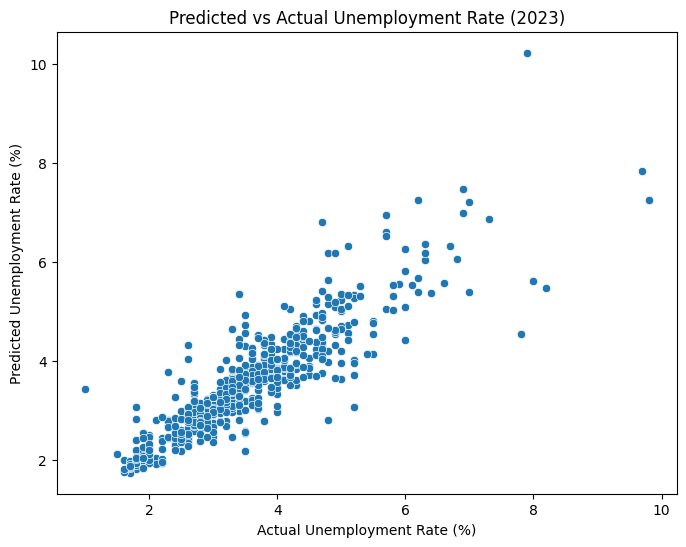

In [54]:


df[variables] = df[variables].apply(pd.to_numeric)

#trim whitespace from column names
df.columns = df.columns.str.strip()

#rename labor force columns to be consistent
df.rename(columns = {'Labor Force_16': 'Force_16', 'Labor Force_17': 'Force_17'}, inplace=True)

#replace all spaces in column names with underscores
df.columns = df.columns.str.replace(' ', '_')

# Normalize year format in column names - using raw strings (r prefix) for regex patterns
df.columns = df.columns.str.replace(r'_(\d{2})$', lambda x: f'_{2000 + int(x.group(1))}', regex=True)  # Convert _YY to _20YY
df.columns = df.columns.str.replace(r'_20(\d{2})$', r'_\1', regex=True)  # Convert _20YY to _YY for consistency
df.columns = df.columns.str.replace(r'(\d{4})$', lambda x: f'_{x.group(1)}', regex=True)  # Add underscore before YYYY if missing

X = df[variables_clean]

# Sort columns alphabetically
X = X.sort_index(axis=1)

# Target is the percentage unemployment in 2023
y = df['(%)_23']

#Train Test split of 80%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# Removing any NaN variable values
X_train_cleaned, y_train_cleaned = X_train.dropna(), y_train.dropna()
X_test = X_test.dropna()
y_test = y_test[X_test.index]

# Hyperparameter creation
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}


# Setting up RandomizedSearchCV for hyperparameters from hyperparameter distribution for my random forest model
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist,
                                   n_iter=10, cv=5, random_state=42, n_jobs=-1)

# Fitting the model for best hyperparameters
random_search.fit(X_train, y_train)

# Output the best parameters
print(f"Best parameters: {random_search.best_params_}")

# Best model with best estimator
best_rf_model = random_search.best_estimator_

# Evaluating the model based on X_test data
y_pred = best_rf_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE of Random Forest with optimized hyperparameters: {rmse}")

# Best parameters are {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
# RMSE of just RF with optimal hyperparameters is .5608

import matplotlib.pyplot as plt
import seaborn as sns

# Data Cleaning
X_train_cleaned, y_train_cleaned = X_train.dropna(), y_train[X_train.dropna().index]
# Fit the Random Forest model with the best parameters from RandomizedSearchCV
random_search.fit(X_train_cleaned, y_train_cleaned)

# Predictions on the test set
y_pred = random_search.predict(X_test)

# Plotting Predicted vs Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Predicted vs Actual Unemployment Rate (2023)')
plt.xlabel('Actual Unemployment Rate (%)')
plt.ylabel('Predicted Unemployment Rate (%)')
plt.show()

In [55]:
# Base Models including optimized hyperparameters for RandomForestRegressor and base models of DecisionTree and LinearRegression
base_models = [
    ('rf', RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=None, random_state=27)),
    ('dt', DecisionTreeRegressor(random_state=27)),
    ('lr', LinearRegression())
]
# Aligning data and removing all NaN
X_train_cleaned, y_train_cleaned = X_train_cleaned.align(y_train_cleaned, join='inner', axis=0)
X_test = X_test[~X_test.isna().any(axis=1)]
y_test = y_test[X_test.index]

# Stacked model
stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression()
)

# Fitting stacked model to training data
stacked_model.fit(X_train_cleaned, y_train_cleaned)

# Predictions based off fit model to X_test
y_pred_stacked = stacked_model.predict(X_test)

# Calculate RMSE for the stacked model
rmse_stacked = np.sqrt(mean_squared_error(y_test, y_pred_stacked))
print("RMSE of Stacked Model: ", rmse_stacked)

# RMSE is improved to .5357 but we still have room to optimize Linear Regression, DecisionTreeRegressor, and add KNNeighbors

RMSE of Stacked Model:  0.5383685374803797


In [56]:
# Ensure clean data and sort features alphabetically
X_train_cleaned = X_train.dropna().sort_index(axis=1)
y_train_cleaned = y_train[X_train_cleaned.index]

# Hyperparameter grid for Decision Tree
param_dist = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'absolute_error'],
    'splitter': ['best', 'random']
}

# Create the DecisionTreeRegressor model
dt_model = DecisionTreeRegressor(random_state=27)

# Randomized SearchCV
random_search_dt = RandomizedSearchCV(dt_model, param_distributions=param_dist, n_iter=100, cv=3, random_state=27)

# Fit the randomized search model
random_search_dt.fit(X_train_cleaned, y_train_cleaned)

# Printing best parameters
print("Best parameters found for DecisionTreeRegressor: ", random_search_dt.best_params_)

#Best Parameters are: {'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': None,
# 'max_depth': 20, 'criterion': 'squared_error'}

# Best model to make predictions
best_dt_model = random_search_dt.best_estimator_

# Predict on the test data
y_pred_dt = best_dt_model.predict(X_test)

# Calculate RMSE for DecisionTreeRegressor
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
print("RMSE of Optimized DecisionTreeRegressor: ", rmse_dt)

# RMSE for DecisionTreeRegressor is .6462

Best parameters found for DecisionTreeRegressor:  {'splitter': 'best', 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 20, 'criterion': 'squared_error'}
RMSE of Optimized DecisionTreeRegressor:  0.617437772553505


In [57]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor

# Optimized Random Forest and Decision Trees from previous model CVs
optimized_rf = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=None)
optimized_dt = DecisionTreeRegressor(splitter='random', min_samples_split=10, min_samples_leaf=1, max_features=None, max_depth=20, criterion='squared_error')

# Fitting base models
optimized_rf.fit(X_train_cleaned, y_train_cleaned)
optimized_dt.fit(X_train_cleaned, y_train_cleaned)

# Creation of Linear Regression meta-model
meta_model = LinearRegression()

# Adding meta model to the rest of base models (stacked model)
stacked_model = StackingRegressor(estimators=[('rf', optimized_rf), ('dt', optimized_dt)], final_estimator=meta_model)

# Train the stacked model
stacked_model.fit(X_train_cleaned, y_train_cleaned)

# Predictions and Evaluation
y_pred = stacked_model.predict(X_test)
rmse_stacked = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE of Stacked Model:", rmse_stacked)

# RMSE of Stacked Model is .5613

RMSE of Stacked Model: 0.5539836427799217


Optimal number of neighbors: 3
Best RMSE for k=3: 0.7460190308640514


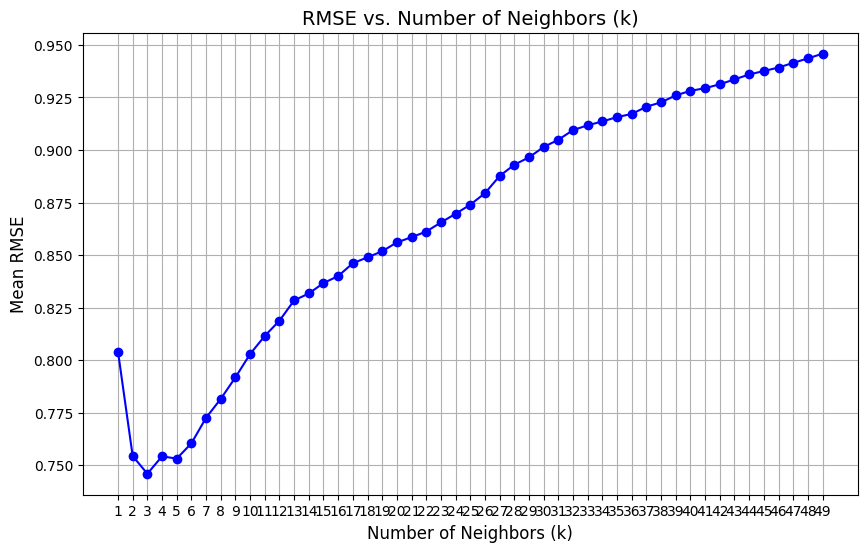

In [58]:
# Define the range of k values to test (1-50)
k_values = range(1, 50)

# Initialize list for Average RMSE score by k value
mean_rmse_scores = []

# Perform KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Loop through the k values
for k in k_values:
    # Define the KNeighborsRegressor model with the current k
    knn_model = Pipeline([
        ('scaler', MinMaxScaler()),
        ('knn', KNeighborsRegressor(n_neighbors=k))
    ])

    # Compute RMSE using cross-validation (use neg_root_mean_squared_error for scoring)
    rmse_scores = cross_val_score(knn_model, X_train_cleaned, y_train_cleaned, cv=kf, scoring='neg_root_mean_squared_error')

    # Append the mean RMSE (positive value) to the list
    mean_rmse_scores.append(-np.mean(rmse_scores))

# Find the optimal k with the lowest mean RMSE score
optimal_k = k_values[np.argmin(mean_rmse_scores)]
best_rmse = np.min(mean_rmse_scores)

# Print the best k and corresponding RMSE
print(f"Optimal number of neighbors: {optimal_k}")
print(f"Best RMSE for k={optimal_k}: {best_rmse}")

# Plot the RMSE scores for each k to visualize the result
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_rmse_scores, marker='o', linestyle='-', color='b')
plt.title('RMSE vs. Number of Neighbors (k)', fontsize=14)
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('Mean RMSE', fontsize=12)
plt.grid(True)
plt.xticks(np.arange(min(k_values), max(k_values) + 1, 1))
plt.show()
plt.show()

In [59]:
# Designing models based off of previous hyperparameter tuning and adding MinMaxScaler and KNeighborsRegressor
dt_model = DecisionTreeRegressor(max_depth=20, min_samples_split=10)
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
knn_model = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=3))
])

# Define the meta-model
meta_model = LinearRegression()

# Create the stacking model
stacked_model = StackingRegressor(
    estimators=[
        ('decision_tree', dt_model),
        ('random_forest', rf_model),
        ('knn', knn_model)
    ],
    final_estimator=meta_model,
    cv=10
)

# Fitting stacked model to
stacked_model.fit(X_train_cleaned, y_train_cleaned)

# Predict on test data
y_pred = stacked_model.predict(X_test)

# Evaluate using RMSE
from sklearn.metrics import mean_squared_error, mean_squared_error as root_mean_squared_error
rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE of Stacked Model: {rmse}")

RMSE of Stacked Model: 0.3017318079897491


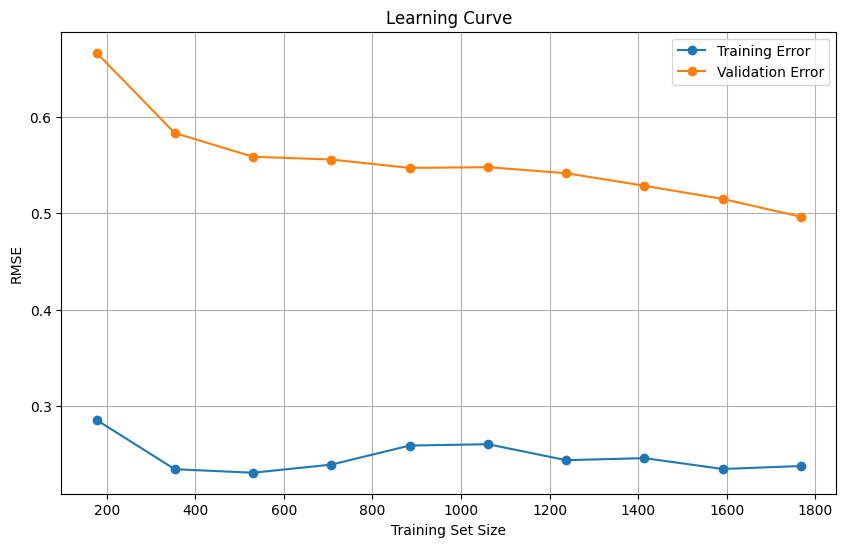

In [60]:
# Split the training data into a training and validation set
X_train_subset, X_val, y_train_subset, y_val = train_test_split(X_train_cleaned, y_train_cleaned, test_size=0.2, random_state=42)

# Define subsets of training sizes (percentages)
training_sizes = np.linspace(0.1, 1.0, 10)  # 10%, 20%, ..., 100%

# Lists to store errors
train_errors = []
val_errors = []

for size in training_sizes:
    # Select a subset of the training data
    subset_size = int(size * len(X_train_subset))
    X_train_sample = X_train_subset[:subset_size]
    y_train_sample = y_train_subset[:subset_size]

    # Train the stacked model on the subset
    stacked_model.fit(X_train_sample, y_train_sample)

    # Calculate RMSE on the training data
    y_train_pred = stacked_model.predict(X_train_sample)
    train_rmse = np.sqrt(mean_squared_error(y_train_sample, y_train_pred))
    train_errors.append(train_rmse)

    # Calculate RMSE on the validation data
    y_val_pred = stacked_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_errors.append(val_rmse)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(training_sizes * len(X_train_subset), train_errors, label="Training Error", marker='o')
plt.plot(training_sizes * len(X_train_subset), val_errors, label="Validation Error", marker='o')
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title("Learning Curve")
plt.legend()
plt.grid()
plt.show()

# King County Stacked Model Inference with Proposed Minimum Wage

In [61]:
print(X_train_cleaned.columns.tolist())

['(%)_13', 'Compensation_(millions_of_dollars)_13', 'Compensation_(millions_of_dollars)_14', 'Compensation_(millions_of_dollars)_15', 'Compensation_(millions_of_dollars)_16', 'Compensation_(millions_of_dollars)_17', 'Compensation_(millions_of_dollars)_18', 'Compensation_(millions_of_dollars)_19', 'Compensation_(millions_of_dollars)_20', 'Compensation_(millions_of_dollars)_21', 'Compensation_(millions_of_dollars)_22', 'Compensation_(millions_of_dollars)_23', 'Current-dollar_GDP_(millions_of_current_dollars)_13', 'Current-dollar_GDP_(millions_of_current_dollars)_14', 'Current-dollar_GDP_(millions_of_current_dollars)_15', 'Current-dollar_GDP_(millions_of_current_dollars)_16', 'Current-dollar_GDP_(millions_of_current_dollars)_17', 'Current-dollar_GDP_(millions_of_current_dollars)_18', 'Current-dollar_GDP_(millions_of_current_dollars)_19', 'Current-dollar_GDP_(millions_of_current_dollars)_20', 'Current-dollar_GDP_(millions_of_current_dollars)_21', 'Current-dollar_GDP_(millions_of_current_do

In [62]:
print(variables)

['Force_13', '(%)_13', 'Labor Force_16', 'Labor Force_17', 'Force_18', 'Force_19', 'Force_20', 'Force_21', 'Force_22', 'Force_23', 'Minimum Wage 2013', 'Minimum Wage 2014', 'Minimum Wage 2015', 'Minimum Wage 2016', 'Minimum Wage 2017', 'Minimum Wage 2018', 'Minimum Wage 2019', 'Minimum Wage 2020', 'Minimum Wage 2021', 'Minimum Wage 2022', 'Minimum Wage 2023', 'Population_2010', 'RUCC_2013', 'Population_2020', 'RUCC_2023', '  Taxes on production and imports (TOPI) (millions of dollars) 2013', '  Taxes on production and imports (TOPI) (millions of dollars) 2014', '  Taxes on production and imports (TOPI) (millions of dollars) 2015', '  Taxes on production and imports (TOPI) (millions of dollars) 2016', '  Taxes on production and imports (TOPI) (millions of dollars) 2017', '  Taxes on production and imports (TOPI) (millions of dollars) 2018', '  Taxes on production and imports (TOPI) (millions of dollars) 2019', '  Taxes on production and imports (TOPI) (millions of dollars) 2020', '  Tax

In [67]:


# Given county and state, find growth rates for all features used in the model
def find_growth_rates(county, state):

  # Calculate CAGR
  def cagr(start_value, end_value, years):
    return (end_value/start_value)**(1/years) - 1

  longform_data = pd.read_csv('longform.csv')
  # Rename column to match wideform
  longform_data.rename(columns={'Force Size': 'Force'}, inplace=True)

  wideform_data = df

  # Filter for county and state
  county_data = longform_data[(longform_data['County Name/State Abbreviation'] == county) & (longform_data['LastTwoLetters'] == state)]

  continuous_metrics = ['Force']
  growth_rates = {}

  for metric in continuous_metrics:
    start_year = county_data['Year'].min()
    end_year = county_data['Year'].max()
    years = end_year - start_year
    start_value = county_data[county_data['Year'] == start_year][metric].iloc[0]
    end_value = county_data[county_data['Year'] == end_year][metric].iloc[0]
    if start_value != 0:
      growth_rates[metric] = cagr(start_value, end_value, years)

  # Get TOPI, Compensation, Current-dollar GDP, Gross operating surplus, Taxes on production and imports (TOPI) less subsides
  # These features are only in wide form data, so getting it with
  wideform_entry = wideform_data[(wideform_data['County_Name/State_Abbreviation'] == county) & (wideform_data['LastTwoLetters'] == state)]
  wide_features = ['Taxes_on_production_and_imports_(TOPI)_(millions_of_dollars)',
    'Compensation_(millions_of_dollars)',
    'Current-dollar_GDP_(millions_of_current_dollars)',
    'Gross_operating_surplus_(millions_of_dollars)',
    'Taxes_on_production_and_imports_(TOPI)_less_subsides_(millions_of_dollars)']
  for metric in wide_features:
    growth_rates[metric] = cagr(wideform_entry[metric + '_13'], wideform_entry[metric + '_23'], 10)
  return growth_rates

# Given a dataframe and growth rates dictionary, will shift all time series features back 2 years
# Problem: 2015 labor force data is missing in training set.
def shift_data(df, growth_rates):
    shifted_df = df.copy()
    new_columns = {}
    columns_to_drop = []

    # For each feature in growth rates, find and drop earliest 2 years
    for feature in growth_rates.keys():
        # Find all columns for this feature by removing year suffix
        base_feature = feature[:-3] if feature[-3] == '_' and feature[-2:].isdigit() else feature
        feature_cols = [col for col in df.columns if col[:-3] == base_feature and col[-2:].isdigit()]

        # Get years for this feature
        years = []
        for col in feature_cols:
            years.append(int(col[-2:]))
        years = sorted(list(set(years)))

        # Mark earliest 2 years for dropping
        if len(years) >= 2:
            earliest_years = years[:2]
            for col in feature_cols:
                if int(col[-2:]) in earliest_years:
                    columns_to_drop.append(col)

    # Drop earliest year columns
    shifted_df = shifted_df.drop(columns=columns_to_drop)

    # Shift remaining years back by 2 for features in growth_rates
    for col in shifted_df.columns:
        if col[-2:].isdigit():
            base_col = col[:-3]  # Remove _YY
            if any(feat.startswith(base_col) for feat in growth_rates.keys()):
                year = int(col[-2:])
                new_year = str(year - 2).zfill(2)
                new_col = base_col + '_' + new_year
                new_columns[col] = new_col
            else:
                new_columns[col] = col
        else:
            new_columns[col] = col

    # Rename columns with shifted years
    shifted_df = shifted_df.rename(columns=new_columns)
    shifted_df = shifted_df.rename(columns={'Force_15': 'Force_13'})
    shifted_df = shifted_df.sort_index(axis=1)
    return shifted_df

# Given a county, state, and a new minimum wage, will prepare the data for prediction
def prepare_king_county_prediction(county, state_abbr, new_min_wage=20.76):
  # First, get growth rates for county
  growth_rates = find_growth_rates(county, state_abbr)
  county_data = df[(df['County_Name/State_Abbreviation'] == county) & (df['LastTwoLetters'] == state_abbr)]
  county_data = county_data[variables_clean]

  # prepare data for input to model
  # some entries are objects.. why?
  # Apply growth rates to county's data for 2024, 2025
  for metric, rate in growth_rates.items():
    county_data[metric + '_24'] = county_data[metric + '_23'].iloc[0] * (1 + rate)
    county_data[metric + '_25'] = county_data[metric + '_23'].iloc[0] * ((1 + rate) ** 2)

  # Create new df with wideform data shifted to 2 years earlier
  shifted_data = shift_data(county_data, growth_rates)
  return shifted_data


prediction_data = prepare_king_county_prediction('King County', 'WA', 20.76)
prediction = stacked_model.predict(prediction_data)
print(prediction)



[2.88688594]


           State County_Name/State_Abbreviation  Force_13 Employed_13  \
2966  Washington                    King County   1137057     1086876   

     Unemployed_13  (%)_13 Unemployed_14  (%)_14  Force_16 Employed_16  ...  \
2966         50181     4.4         52429     4.5   1213173     1166951  ...   

     Taxes_on_production_and_imports_(TOPI)_less_subsides_(millions_of_dollars)_14  \
2966                                            33971.0                              

      Taxes_on_production_and_imports_(TOPI)_less_subsides_(millions_of_dollars)_15  \
2966                                            35817.6                               

      Taxes_on_production_and_imports_(TOPI)_less_subsides_(millions_of_dollars)_16  \
2966                                            38208.5                               

     Taxes_on_production_and_imports_(TOPI)_less_subsides_(millions_of_dollars)_17  \
2966                                            40969.2                              

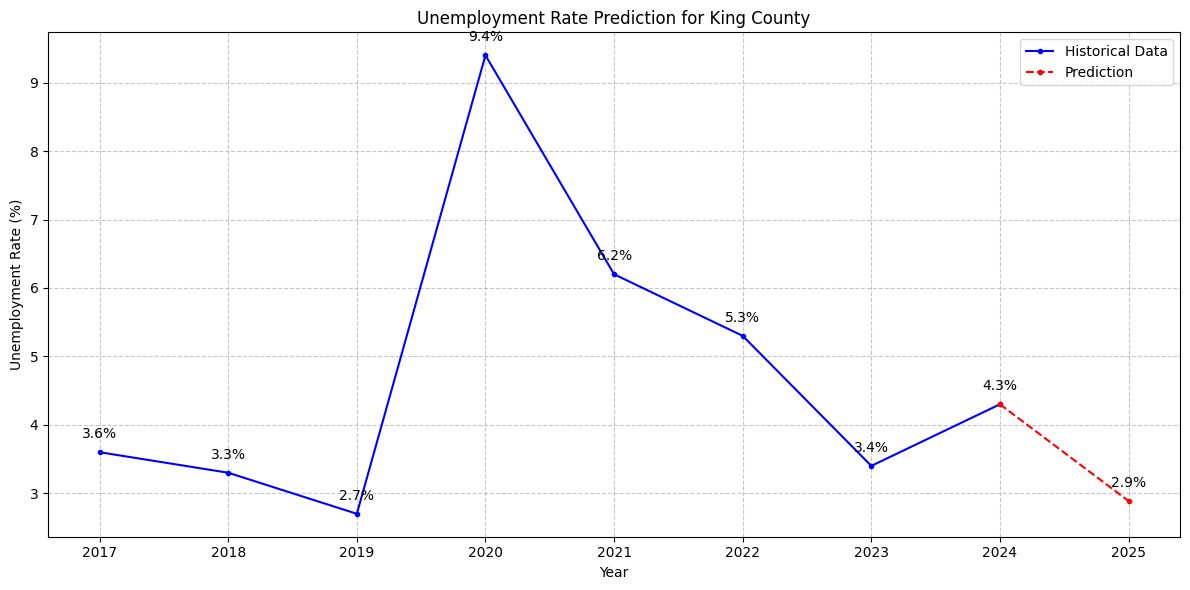

In [68]:
# Graph prediction with old data
def plot_prediction_with_history(df, prediction, county_name='King County'):
    # Get historical data for the specified county
    historical_data = df[(df['County_Name/State_Abbreviation'] == county_name) & (df['State'] == 'Washington')]
    print(historical_data)
    # Create figure and axis
    plt.figure(figsize=(12, 6))

    # Plot historical unemployment rates
    # years = range(2016, 2025)  # From 2016 to 2023, plus prediction for 2025
    # historical_rates = [
    #     historical_data[f'(%)_{str(year)[2:]}'].iloc[0] if year < 2024 and f'(%)_{str(year)[2:]}' in historical_data.columns
    #     else prediction[0] if year == 2025  # Use prediction for 2025
    #     else None for year in years
    # ]

    years = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
    # Plot historical unemployment rates
    historical_rates = [
        historical_data['(%)_17'].iloc[0],
        historical_data['(%)_18'].iloc[0],
        historical_data['(%)_19'].iloc[0],
        historical_data['(%)_20'].iloc[0],
        historical_data['(%)_21'].iloc[0],
        historical_data['(%)_22'].iloc[0],
        historical_data['(%)_23'].iloc[0],
        4.3, # 2024 from https://fred.stlouisfed.org/series/WAKING5URN
        prediction[0]
    ]

    # Create the plot
    plt.plot(years[:-1], historical_rates[:-1], 'b.-', label='Historical Data')
    plt.plot(years[-2:], historical_rates[-2:], 'r.--', label='Prediction')

    # Customize the plot
    plt.title(f'Unemployment Rate Prediction for {county_name}')
    plt.xlabel('Year')
    plt.ylabel('Unemployment Rate (%)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Add value labels
    for i, rate in enumerate(historical_rates):
        plt.annotate(f'{rate:.1f}%',
                    (years[i], rate),
                    textcoords="offset points",
                    xytext=(0,10),
                    ha='center')

    plt.tight_layout()
    plt.show()

# Usage:
plot_prediction_with_history(df, prediction)

3.4
      (%)_13  Compensation_(millions_of_dollars)_13  \
2966     4.4                               235950.2   

      Compensation_(millions_of_dollars)_14  \
2966                               250024.7   

      Compensation_(millions_of_dollars)_15  \
2966                               267847.3   

      Compensation_(millions_of_dollars)_16  \
2966                               290656.1   

      Compensation_(millions_of_dollars)_17  \
2966                               309606.9   

      Compensation_(millions_of_dollars)_18  \
2966                               322662.9   

      Compensation_(millions_of_dollars)_19  \
2966                               353102.6   

      Compensation_(millions_of_dollars)_20  \
2966                               376411.0   

      Compensation_(millions_of_dollars)_21  ...  \
2966                               407169.7  ...   

      Taxes_on_production_and_imports_(TOPI)_less_subsides_(millions_of_dollars)_14  \
2966                        

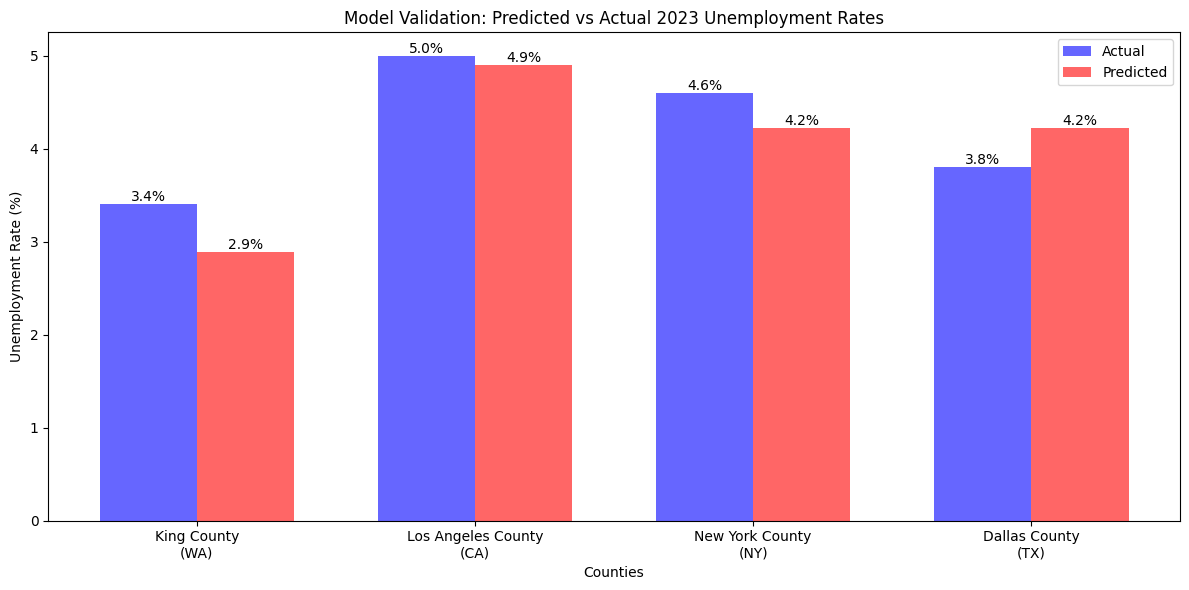

In [69]:
# Validate model against other similar counties
# LA, New York, Dallas

def validate_model_predictions(model, df, counties):
    """
    Validate model predictions against actual 2023 data for specified counties

    Parameters:
    model: trained model
    df: DataFrame containing the data
    counties: list of tuples containing (county_name, state_abbr)
    """
    results = []

    for county, state in counties:
        # Prepare data for prediction (using data up to 2022 to predict 2023)
        county_data = df[(df['County_Name/State_Abbreviation'] == county) &
                        (df['LastTwoLetters'] == state)].copy()

        # Get actual 2023 value
        actual_2023 = county_data['(%)_23'].iloc[0]
        print(actual_2023)

        # Prepare prediction data (use data up to 2022)
        prediction_data = prepare_king_county_prediction(county, state)
        print(prediction_data)

        # Get prediction
        predicted_2023 = model.predict(prediction_data)[0]

        # Calculate error
        error = abs(predicted_2023 - actual_2023)

        results.append({
            'County': county,
            'State': state,
            'Actual_2023': actual_2023,
            'Predicted_2023': predicted_2023,
            'Absolute_Error': error
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Print results
    print("\nModel Validation Results:")
    print(results_df)
    print(f"\nMean Absolute Error: {results_df['Absolute_Error'].mean():.2f}%")

    # Create visualization
    plt.figure(figsize=(12, 6))
    x = range(len(counties))
    width = 0.35

    plt.bar([i - width/2 for i in x], results_df['Actual_2023'],
           width, label='Actual', color='blue', alpha=0.6)
    plt.bar([i + width/2 for i in x], results_df['Predicted_2023'],
           width, label='Predicted', color='red', alpha=0.6)

    plt.xlabel('Counties')
    plt.ylabel('Unemployment Rate (%)')
    plt.title('Model Validation: Predicted vs Actual 2023 Unemployment Rates')
    plt.xticks(x, [f"{county}\n({state})" for county, state in counties])
    plt.legend()

    # Add value labels
    for i in x:
        plt.text(i - width/2, results_df['Actual_2023'].iloc[i],
                f"{results_df['Actual_2023'].iloc[i]:.1f}%",
                ha='center', va='bottom')
        plt.text(i + width/2, results_df['Predicted_2023'].iloc[i],
                f"{results_df['Predicted_2023'].iloc[i]:.1f}%",
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Usage
counties_to_validate = [
    ('King County', 'WA'),
    ('Los Angeles County', 'CA'),
    ('New York County', 'NY'),
    ('Dallas County', 'TX')
]

validate_model_predictions(stacked_model, df, counties_to_validate)